In [1]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SqxHxUmH1bESmMpTc8Wo")
project = rf.workspace("field-planttutorial").project("field-plant")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Field-plant-2 in yolov11:: 100%|██████████| 9862/9862 [00:12<00:00, 819.55it/s] 


In [3]:
# Import necessary libraries
import torch
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
import os
import pandas as pd
from collections import Counter

labels_path = "/kaggle/working/Field-plant-2/train/labels/"
label_files = os.listdir(labels_path)

class_counts = Counter()

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        for line in f:
            class_id = line.split()[0]
            class_counts[class_id] += 1

df = pd.DataFrame(class_counts.items(), columns=["Class ID", "Count"])
print(df.sort_values("Count", ascending=True))



   Class ID  Count
25        6      1
23       16      6
21       12      7
24       13      8
16       25     11
20       17     13
22       10     13
14        0     17
19        7     21
12        8     27
11       20     30
6        11     33
18        4     50
8        26     75
2        15    113
1         9    115
17        1    128
13        5    156
7        14    180
15       24    190
10       23    273
5         2    286
9        18    338
4        21   1142
0        19   1164
3         3   1367


In [5]:
if class_id in ['6', '16', '12', '13', '25']:  # Undersampled classes
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.5),  # Higher probability
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
        A.Rotate(limit=30, p=0.7),  # More aggressive rotation
        A.Blur(blur_limit=3, p=0.3),
        A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5)  # Add cutout for more diversity
    ])
else:
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.Blur(blur_limit=3, p=0.2)
    ])


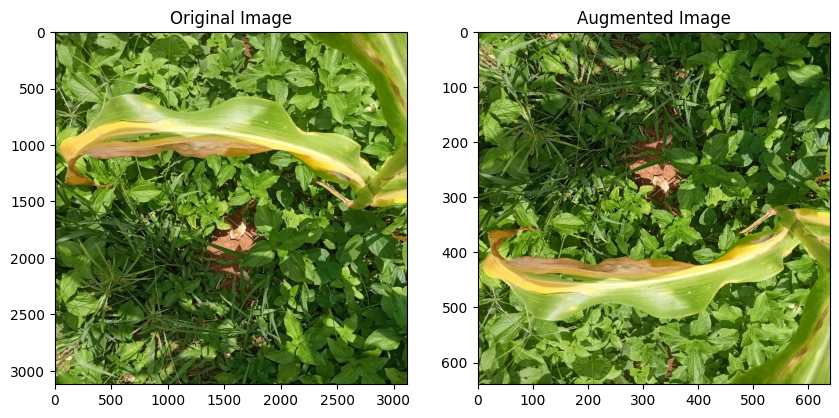

In [6]:
# Path to training images and labels
train_images_path = "/kaggle/working/Field-plant-2/train/images/"
train_labels_path = "/kaggle/working/Field-plant-2/train/labels/"

# Load and preprocess a sample image
sample_image_path = os.path.join(train_images_path, os.listdir(train_images_path)[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = transform(image=image)["image"]

# Display the original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
plt.show()

In [7]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Feature Mapping using PCA
def feature_mapping(image_path, pca_components=10):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_flat = img.reshape(64, 64)  # Keep 2D structure

    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)  # Normalize pixel values

    pca = PCA(n_components=min(pca_components, img_scaled.shape[1]))  # Ensure valid component count
    img_pca = pca.fit_transform(img_scaled)  # Apply PCA

    return img_pca

# Test with sample image
feature_map = feature_mapping(sample_image_path, pca_components=10)
print("Feature Mapping Output Shape:", feature_map.shape)


Feature Mapping Output Shape: (64, 10)


In [8]:
!yolo detect train data=/kaggle/working/Field-plant-2/data.yaml \
    model=yolo11l.pt \
    epochs=40 batch=16 lr0=0.0001 imgsz=640 iou=0.7 \
    optimizer=AdamW weight_decay=0.0005 momentum=0.9 \
    hsv_h=0.02 hsv_s=0.8 hsv_v=0.5 mosaic=1.0 mixup=0.3 dropout=0.3 copy_paste=0.2\
    cos_lr=True \
    project=/kaggle/working/Field-plant-2/training_results name=run_finetuned_v3


100%|███████████████████████████████████████| 49.0M/49.0M [00:00<00:00, 243MB/s]
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/Field-plant-2/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/Field-plant-2/training_results, name=run_finetuned_v3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

In [9]:
!yolo detect val \
    data=/kaggle/working/Field-plant-2/data.yaml \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 imgsz=640 iou=0.8 \
    project=/kaggle/working/Field-plant-2/training_results \
    name=val_results



Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,300,129 parameters, 0 gradients, 86.7 GFLOPs
val: Scanning /kaggle/working/Field-plant-2/valid/labels.cache... 734 images, 0 
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        734       1226      0.709      0.686      0.748      0.614
Cassava Bacterial Blight          3          4          0          0      0.125     0.0481
Cassava Brown Leaf Spot         27         28      0.487      0.643      0.511      0.449
       Cassava Healthy         47         63      0.794       0.81      0.833      0.722
        Cassava Mosaic        150        272      0.808      0.776      0.863      0.688
      Cassava Root Rot         17         18      0.659      0.389      0.567      0.461
      Corn Brown Spots         30         37      0.719      0.554      0.702      0.529
Corn Chlorotic Leaf Spot          3          

In [10]:
!yolo detect val \
    data=/kaggle/working/Field-plant-2/data.yaml \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 imgsz=640 iou=0.8 \
    project=/kaggle/working/Field-plant-2/training_results \
    name=test_results \
    split=test


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,300,129 parameters, 0 gradients, 86.7 GFLOPs
val: Scanning /kaggle/working/Field-plant-2/test/labels... 737 images, 0 backgro
val: New cache created: /kaggle/working/Field-plant-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        737       1207      0.683      0.661        0.7      0.554
Cassava Bacterial Blight          2          4          0          0     0.0794     0.0732
Cassava Brown Leaf Spot         30         37      0.709      0.811      0.741      0.634
       Cassava Healthy         40         68      0.806      0.706      0.796      0.665
        Cassava Mosaic        159        251      0.817      0.837      0.911      0.745
      Cassava Root Rot          8          9      0.745      0.651      0.665      0.616
      Corn Brown Spots         22         27      0.839      0